In [232]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error
import os

In [233]:
import warnings
warnings.filterwarnings('ignore')

In [234]:

Path_Energy = '/home/mikhail/Рабочий стол/ML_BI_042020/my_PJME_MW.csv'
# Path_Energy = '/home/mikhail/Рабочий стол/ML_BI_042020/PJME_hourly.csv'

df = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [235]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [236]:
# Ресемплинг
d_res=df.resample('D').mean()

In [237]:
d_res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6059 entries, 2002-01-01 to 2018-08-03
Freq: D
Data columns (total 12 columns):
PJME_MW            6059 non-null float64
year               6059 non-null float64
month              6059 non-null float64
dayofmonth         6059 non-null float64
quarter            6059 non-null float64
dayofyear          6059 non-null float64
weekofyear         6059 non-null float64
dayofweek          6059 non-null float64
hour               6059 non-null float64
is_holiday         6059 non-null float64
is_prev_holiday    6059 non-null float64
is_next_holiday    6059 non-null float64
dtypes: float64(12)
memory usage: 615.4 KB


In [238]:
# Экспоненциальное сглаживание
data_exp_1 = exponential_smoothing(d_res['PJME_MW'], 0.05)

In [239]:
# Прибавим даты
data_exp_1 = pd.DataFrame(data = data_exp_1, index = d_data.index)

In [240]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()



In [241]:
split_date = '2010-01-01'

In [242]:

train, test = split_data(data_exp_1, split_date)

In [243]:
model = CatBoostRegressor(learning_rate=0.1, depth=10, loss_function='MAE', bootstrap_type='Bernoulli')

In [244]:
h=1 # шаг вперед-шаг назад
X_train_1 = train.iloc[:-h,:]
y_train_1 = train[data_exp_1.columns[0]].values[h:]
X_test_1 = test.iloc[:-h,:]
y_test_1 = test[data_exp_1.columns[0]].values[h:]

In [245]:
model.fit(X_train_1, y_train_1 ) 
X_test_pred_1 = model.predict(X_test_1)

0:	learn: 2177.3048454	total: 102ms	remaining: 1m 41s
1:	learn: 1969.1981496	total: 189ms	remaining: 1m 34s
2:	learn: 1790.4698671	total: 199ms	remaining: 1m 6s
3:	learn: 1617.3192823	total: 281ms	remaining: 1m 10s
4:	learn: 1461.7501515	total: 364ms	remaining: 1m 12s
5:	learn: 1322.3359203	total: 446ms	remaining: 1m 13s
6:	learn: 1197.0842452	total: 530ms	remaining: 1m 15s
7:	learn: 1097.1542122	total: 538ms	remaining: 1m 6s
8:	learn: 999.6904513	total: 621ms	remaining: 1m 8s
9:	learn: 906.9080280	total: 705ms	remaining: 1m 9s
10:	learn: 824.4965954	total: 787ms	remaining: 1m 10s
11:	learn: 755.5114045	total: 871ms	remaining: 1m 11s
12:	learn: 688.0662303	total: 954ms	remaining: 1m 12s
13:	learn: 626.6462406	total: 1.04s	remaining: 1m 12s
14:	learn: 573.3260349	total: 1.12s	remaining: 1m 13s
15:	learn: 533.4167237	total: 1.2s	remaining: 1m 13s
16:	learn: 489.3507523	total: 1.28s	remaining: 1m 14s
17:	learn: 453.5458527	total: 1.31s	remaining: 1m 11s
18:	learn: 416.9713592	total: 1.39s

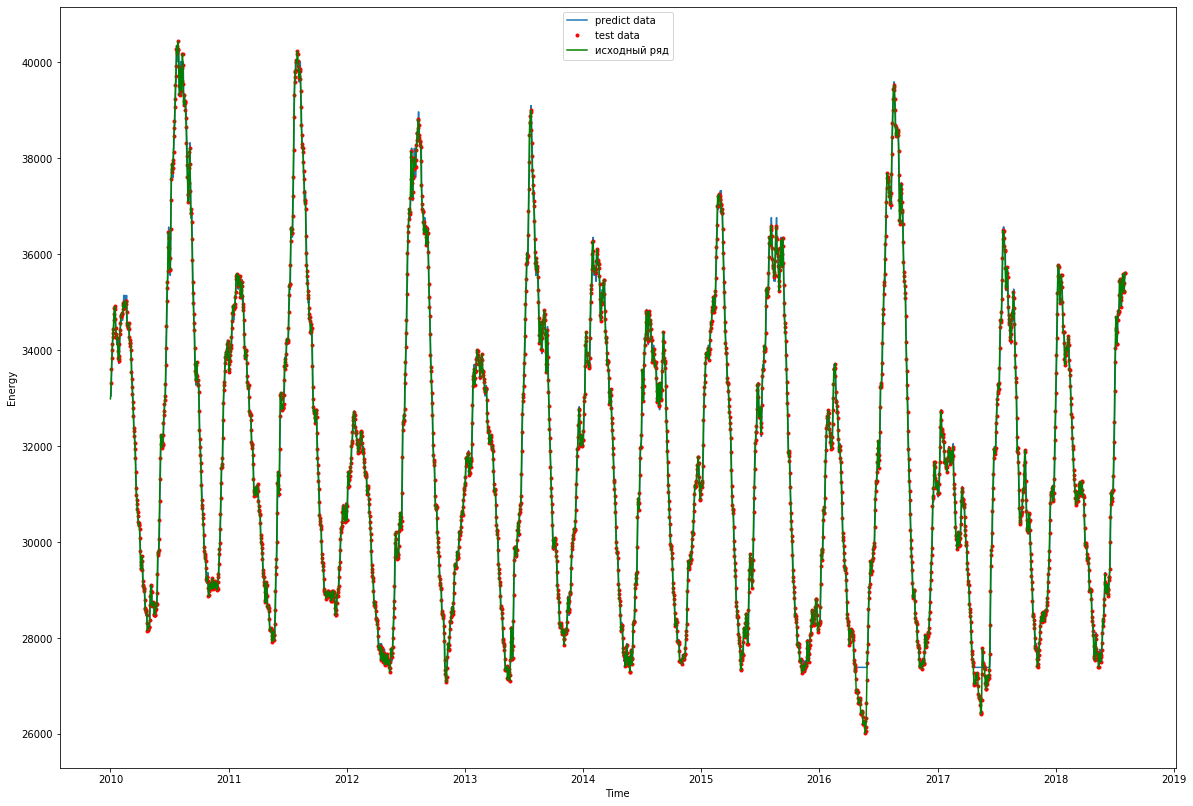

In [246]:
plt.figure( figsize=( 20, 14 ))

plt.xlabel('Время')
plt.ylabel('Потребление')
plt.plot(test.index[h:],X_test_pred_1, label='predict data' )
plt.plot(test.index[h:], y_test_1, '.r', label='test data')
plt.plot(data_exp_1.loc[split_date:].index, data_exp_1.loc[split_date:][0], 'g', label='исходный ряд')

plt.legend(loc='upper center')
plt.show()


In [247]:

h=10
X_train_10 = train.iloc[:-h,:]
y_train_10 = train[data_exp_1.columns[0]].values[h:]
X_test_10 = test.iloc[:-h,:]
y_test_10 = test[data_exp_1.columns[0]].values[h:]


model.fit(X_train_10, y_train_10 ) 
X_test_pred_10 = model.predict(X_test_10)


0:	learn: 2206.9894216	total: 108ms	remaining: 1m 48s
1:	learn: 2025.5335267	total: 211ms	remaining: 1m 45s
2:	learn: 1865.4262938	total: 296ms	remaining: 1m 38s
3:	learn: 1726.8252302	total: 378ms	remaining: 1m 34s
4:	learn: 1605.1402064	total: 461ms	remaining: 1m 31s
5:	learn: 1502.3080031	total: 546ms	remaining: 1m 30s
6:	learn: 1411.2630682	total: 629ms	remaining: 1m 29s
7:	learn: 1331.7042829	total: 713ms	remaining: 1m 28s
8:	learn: 1263.0107972	total: 796ms	remaining: 1m 27s
9:	learn: 1207.0684715	total: 879ms	remaining: 1m 27s
10:	learn: 1155.9545769	total: 965ms	remaining: 1m 26s
11:	learn: 1115.0948176	total: 1.01s	remaining: 1m 23s
12:	learn: 1079.4610711	total: 1.05s	remaining: 1m 19s
13:	learn: 1047.1680110	total: 1.14s	remaining: 1m 20s
14:	learn: 1019.8067049	total: 1.22s	remaining: 1m 20s
15:	learn: 998.2984466	total: 1.3s	remaining: 1m 20s
16:	learn: 979.2299168	total: 1.38s	remaining: 1m 20s
17:	learn: 963.1610156	total: 1.47s	remaining: 1m 20s
18:	learn: 950.9540110	t

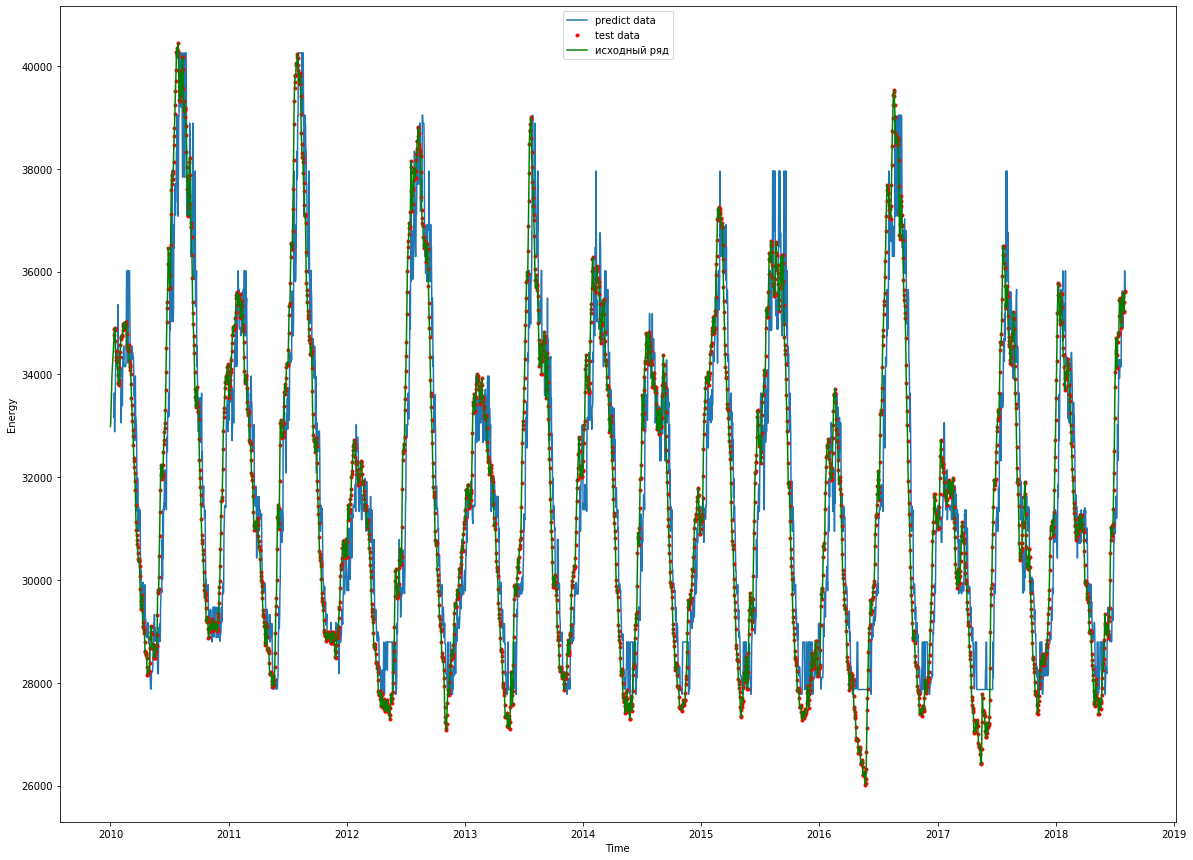

In [248]:

plt.figure( figsize=(20, 15))

plt.xlabel('Время')
plt.ylabel('Потребление')
plt.plot(test.index[h:],X_test_pred_10, label='predict data' )
plt.plot(test.index[h:], y_test_10, '.r', label='test data')
plt.plot(data_exp_1.loc[split_date:].index, data_exp_1.loc[split_date:][0], 'g', label='исходный ряд')

plt.legend(loc='upper center')
plt.show()


In [250]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


error_1 = mean_absolute_percentage_error(y_true=y_test_1, y_pred=X_test_pred_1)
error_10 = mean_absolute_percentage_error(y_true=y_test_10, y_pred=X_test_pred_10)

print(f'Oшибка модели бустинга при h = 1:  {error_1:.3f} %, \nошибка модели бустинга при h = 10:  {error_10:.3f} %' )



Oшибка модели бустинга при h = 1:  0.507 %, 
ошибка модели бустинга при h = 10:  3.326 %


Ошибка нарастает из-за большей перспективы (чем дальше - тем туманней)

In [ ]:
 а) Изменение температуры за окном :). Стационарный и  циклический

б) Количество денег, которые тратят покупатели в интернет магазине. Стационарный.

в) Вес растущего котенка. Нестационарный.

г) Прирост объема деревьев в лесу от времени. Нестационарный